In [2]:
import sys,tweepy
import numpy as np
import pandas as pd
import warnings

from nltk.corpus import stopwords
from nltk.corpus import words
#nltk.download('stopwords')
#nltk.download('punkt')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

from wordcloud import WordCloud

warnings.filterwarnings("ignore")

In [3]:
#Authentication
def twitter_auth():
    try:
        consumer_key = '---'
        consumer_secret = '---'
        access_token = '---'
        access_secret = '---'
    except KeyError:
        sys.stderr.write("Enviornment variable not set\n")
        sys.exit(1)
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    return auth

def get_twitter_client():
    auth = twitter_auth()
    api = tweepy.API(auth, wait_on_rate_limit=True)
    return api

#Get tweets from user since May 1st
def processTweets():
    user = "BarackObama"
    api = get_twitter_client()
    status = tweepy.Cursor(api.user_timeline, id = user, tweet_mode = "extended", lang = 'en', exclude_replies = True, include_rts = False).items(15)

    tweet_list = [tweets.full_text for tweets in status]
    group_words = []
    for tweet in tweet_list:
        word_list = []
        for word in tweet.split():
            if word.isalpha():
                word_list.append(word)
        group_words.append(' '.join(word_list))

    return group_words

In [4]:
def tokenizer(keyword):
    return [word for word in keyword.split(' ') if (word in words.words())]

In [5]:
keywords = processTweets()
tfidf = TfidfVectorizer(tokenizer=tokenizer, stop_words=stopwords.words('english'), norm='l2') #Term frequency - inverse document frequency
#X = pd.DataFrame(tfidf.fit_transform(keywords).toarray(), index=keywords, columns=tfidf.get_feature_names())
#print(X) #Display each feature with tfidf of each keyword
features = tfidf.fit_transform(keywords) #Learn vocab and idf

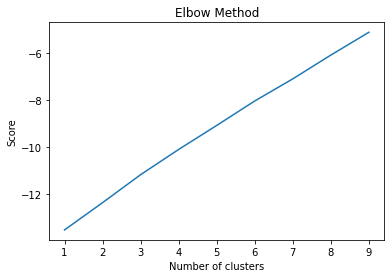

In [6]:
#Determine best value for k
opt_cluster = range(1, 10)
kmeans = [KMeans(n_clusters=i,max_iter=200) for i in opt_cluster]
score = [kmeans[i].fit(features).score(features) for i in range(len(kmeans))]
plt.plot(opt_cluster, score)
plt.xticks([*opt_cluster])
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

In [7]:
#K-Means Clustering
k = 5
model = KMeans(n_clusters=k, init='k-means++', n_init=2, max_iter=100)
kmeans = model.fit(features)
prediction = kmeans.predict(features)

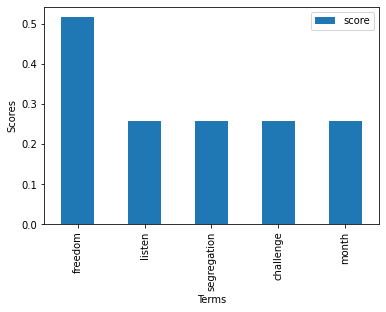

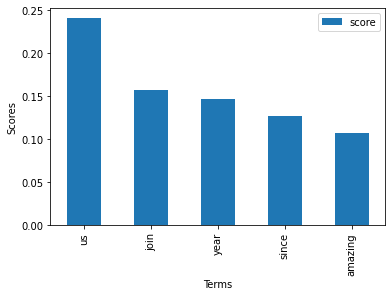

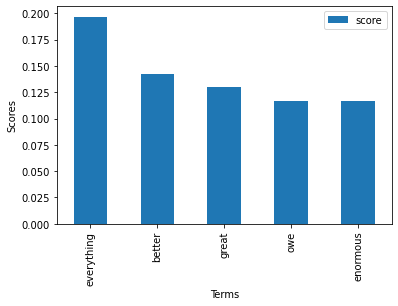

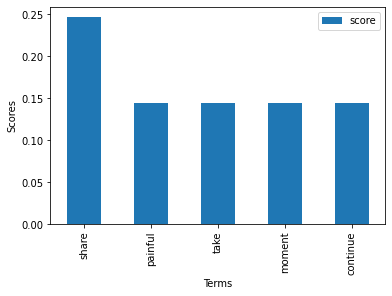

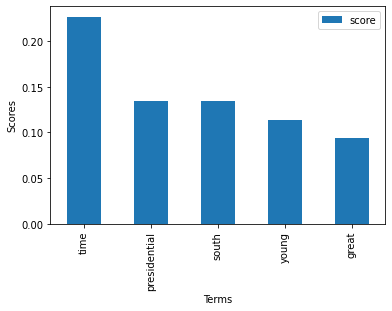

In [46]:
#Top 5 terms with best score from each cluster
terms = tfidf.get_feature_names()
labels = np.unique(prediction)
tfidf_array = features.toarray()
all_terms = []

for label in labels:
    index = np.where(prediction == label)
    means = np.mean(tfidf_array[index], axis = 0)#average score for each cluster
    sorted_mean = np.argsort(means)[::-1][:5]#top 5 scores
    best_terms = [(terms[i], means[i]) for i in sorted_mean]
    
    all_terms.append([terms[i] for i in np.argsort(means)[::-1][:]])
    
    graph = pd.DataFrame(best_terms,columns=['features','score'])
    graph.plot.bar(x='features', y='score')
    plt.ylabel('Scores')
    plt.xlabel('Terms')

plt.show()

TypeError: 'Figure' object is not callable

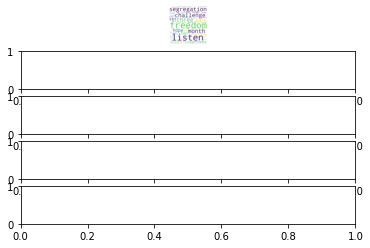

In [53]:
#Print word clouds for each cluster. With larger fonts being the feature with the higher score
x = 0
figure, ax = plt.subplots(5)
for cluster in all_terms:
    word_cloud = WordCloud(width=400, height=400, background_color = 'white', min_font_size=10, prefer_horizontal = True).generate(' '.join(cluster))
    ax[x].imshow(word_cloud)
    ax[x].axis("off")
    ax[x].figure(figsize = (20,20))
    x = x + 1
plt.show()

In [ ]:
#Print clusters
order_centroids = kmeans.cluster_centers_.argsort()[:,::-1]
for i in range(k):
    print("cluster ID %d: " % i)
    for j in order_centroids[i,:]:
        print(' %s' % terms[j])
    print('--------------------------------')
    